In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer

### Read the House Dataset

In [4]:
House_dataset=pd.read_csv("House_dataset.csv")

### Spliting the features and target Variable

In [8]:
X=House_dataset.drop(['List Price','Sold Price', 'Days on Market','Sale to List %','price class', 'log price'],axis=1)
Y=House_dataset[['Sold Price','log price',"price class",'List Price']]

### Dataset Standardization and scaling

In [9]:
from sklearn.preprocessing import StandardScaler
def X_norm(df):
    ndf=pd.DataFrame()
    for col in df.columns:
        #norm btw 0 and 1
        ndf[col]=df[col]/max(df[col])
    #Z_score for 'Taxes' and 'Maint. Fees'
    std_scaler = StandardScaler()
    ndf[['Taxes']] = std_scaler.fit_transform(ndf[['Taxes']].values.tolist())
    return ndf

nX=X_norm(X)
nY=Y.copy(deep=True)
_MAX_Y=max(Y['Sold Price'])
nY['Sold Price']=Y['Sold Price']/_MAX_Y
nY['List Price']=Y['List Price']/_MAX_Y

### Creating Training and Test Sets House dataset

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(nX, nY, test_size=0.15,stratify=nY[["price class"]])

### Goodness of fit function 

In [17]:
def GoF(y_true, y_pred,summary=True,plot=True,title='cumulative distribution of APE Curve'):
    APE=np.abs((y_true - y_pred) / y_true)
    score=[]
    N=len(y_true)
    for i in range(101):
        T=sum(APE<=i/100.0)
        score.append(T/N)
    AUC=np.trapz(score, dx=0.01)
    MAPE=np.average(np.abs(y_true - y_pred) / y_true, axis=0)*100
    RMSE=np.sqrt(mean_squared_error(y_true, y_pred))
    R2=r2_score(y_true, y_pred)
    dict_error={'Value':[_MAX_Y*RMSE,R2,MAPE,AUC]}
    index_error=['RMSE','R2','MAPE%',"AUC"]
    df = pd.DataFrame(dict_error,index=index_error)
    
    if plot:
        plt.figure(figsize=(5, 5))
        plt.plot(np.linspace(0,1.01,101),score,label=f'AUC = {round(AUC,2)}')
        plt.plot(0.05,score[5],'rs', label=f'APE<5% : {round(score[5]*100,2)}%')
        plt.plot(0.10,score[10],'rD', label=f'APE<10% : {round(score[10]*100,2)}%')
        plt.plot(0.20,score[20],'ro', label=f'APE<20% : {round(score[20]*100,2)}%')
        plt.legend()
        plt.title(title)
        plt.xlabel('APE')
        plt.ylabel('Cumulative distribution')
        plt.show()
        
    if summary:
        print(round(df,2).T)
        
    return score,df

######### Custom Grid Search score functions #########
def GS_score(y_true, y_pred):# y=Sold price 
    _,ES=GoF(y_true,y_pred,summary=False,plot=False)
    return (ES.T)['AUC'].values

def Log_GS_score(y_true, y_pred):# y=Log of sold price
    _,ES=GoF(np.exp(y_true),np.exp(y_pred),summary=False,plot=False)
    return (ES.T)['AUC'].values

######### Mean of APE curve & its margins ######### 
def CDF_plot(CDF_mean,CDF_std,title="K-Fold Result"):
    x=np.linspace(0,1.01,101)
    plt.figure(figsize=(5, 5))
    plt.plot(x,CDF_mean,label='mean')
    plt.plot(x,CDF_mean+2*CDF_std,'--',label='mean+2*std')
    plt.plot(x,CDF_mean-2*CDF_std,'--',label='mean-2*std')
    plt.legend()
    plt.title(title)
    plt.xlabel('APE')
    plt.ylabel('Cumulative distribution')
    plt.show()
    

### Base Line

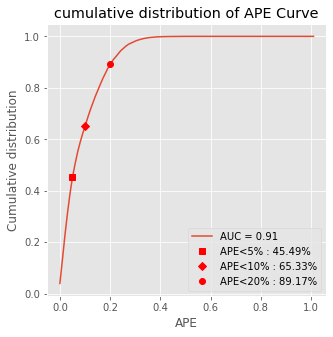

            RMSE    R2  MAPE%   AUC
Value  150867.17  0.91   8.59  0.91


In [19]:
######### The homeowner listed a value to sale as a list price ######### 
score,ES=GoF(nY['Sold Price'],nY['List Price'])

## Linear Regression Model

### Base Learner

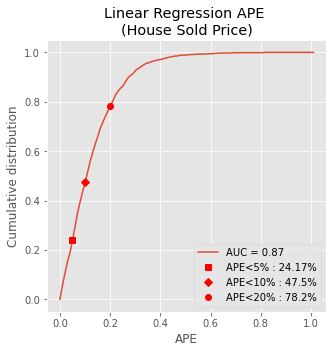

            RMSE    R2  MAPE%   AUC
Value  202868.69  0.84  13.13  0.87


In [20]:
LR= LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
y_pred=LR.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="Linear Regression APE \n(House Sold Price)")

#### K-Fold Cross Validation for LR model,(target:sold price) K=50

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   201330.296  16104.773
R2          0.840      0.020
MAPE%      13.010      0.613
AUC         0.870      0.006


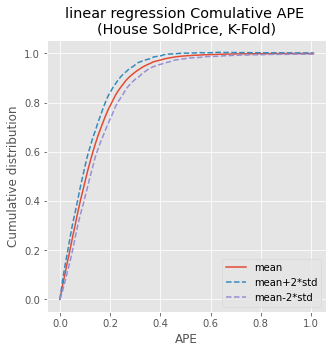

             mean       std
APE<5%   0.253220  0.026539
APE<10%  0.482854  0.031418
APE<20%  0.790731  0.026905


In [8]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR= LinearRegression().fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])                            
    y_pred=LR.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="linear regression Comulative APE \n(House SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

#### Linear regression with log price

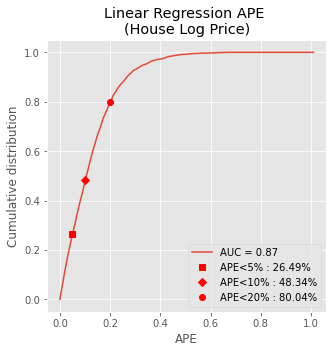

            RMSE    R2  MAPE%   AUC
Value  237025.11  0.78  12.73  0.87


In [12]:
LR= LinearRegression()
LR.fit(X_train, Y_train['log price'])
y_pred=np.exp(LR.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred,title="Linear Regression APE \n(House Log Price)")

#### K-Fold Cross Validation(Log Price)

             mean        std
RMSE   230200.738  22855.644
R2          0.791      0.031
MAPE%      12.857      0.647
AUC         0.872      0.006


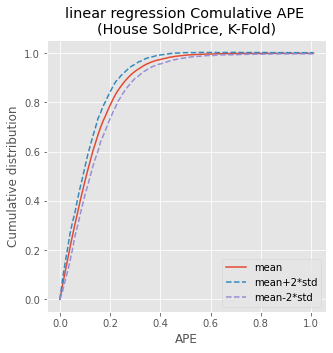

             mean       std
APE<5%   0.260713  0.027083
APE<10%  0.485819  0.028471
APE<20%  0.792301  0.027016


In [9]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR= LinearRegression().fit(nX.iloc[train_index], nY.iloc[train_index]['log price'])                            
    y_pred=np.exp(LR.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="linear regression Comulative APE \n(House SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

## KNN

#### Hyperparameter Optimization With Grid Search, Target (Sold Price)

In [30]:
AUC = make_scorer(GS_score)
parameters = {'n_neighbors':range(6,19)}
KNN_base = KNeighborsRegressor(weights='distance',algorithm='brute', p=1,metric='minkowski') 
KNN_tuned = GridSearchCV(KNN_base, parameters,cv = 5,scoring= AUC)
KNN_opt_sold=KNN_tuned.fit(X_train, Y_train['Sold Price'])
print("Best AUC: " + str(KNN_opt_sold.best_score_) + "\n")
print("Optimal Model:\n" + str(KNN_opt_sold.best_estimator_) + "\n")
print(KNN_opt_sold.best_params_)

Best AUC: 0.8704095826893352

Optimal Model:
KNeighborsRegressor(algorithm='brute', n_neighbors=11, p=1, weights='distance')

{'n_neighbors': 11}


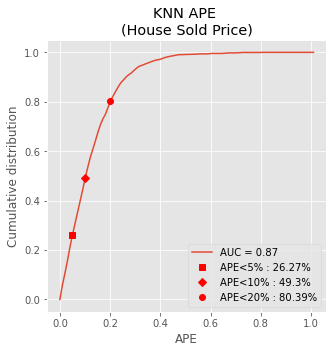

           RMSE    R2  MAPE%   AUC
Value  200079.5  0.84  12.71  0.87


In [31]:
y_pred=KNN_opt_sold.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="KNN APE \n(House Sold Price)")

### K-Fold for KNN(Sold price)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   199832.212  16572.124
R2          0.841      0.025
MAPE%      12.673      0.739
AUC         0.873      0.007


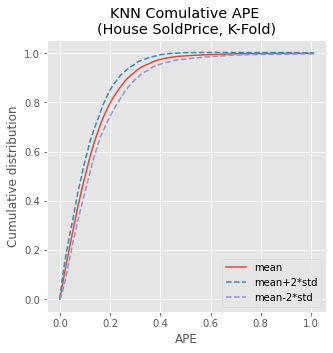

             mean       std
APE<5%   0.271355  0.022800
APE<10%  0.502962  0.031639
APE<20%  0.800775  0.026360


In [10]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    KNN= KNeighborsRegressor(n_neighbors=11,weights='distance',algorithm='brute', p=1,
                             metric='minkowski').fit(nX.iloc[train_index],
                                                     nY.iloc[train_index]['Sold Price'])
    y_pred=KNN.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="KNN Comulative APE \n(House SoldPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

#### Hyperparameter Optimization With Grid Search, Target (log price)

In [20]:
AUC = make_scorer(GS_score)
parameters = {'n_neighbors':range(6,19)}
KNN_base = KNeighborsRegressor(weights='distance',algorithm='brute', p=1,metric='minkowski') 
KNN_tuned = GridSearchCV(KNN_base, parameters,cv = 5,scoring= AUC)
KNN_opt_log=KNN_tuned.fit(X_train, Y_train['log price'])
print("Best AUC: " + str(KNN_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(KNN_opt.best_estimator_) + "\n")
print(KNN_opt.best_params_)

Best AUC: 0.8704095826893352

Optimal Model:
KNeighborsRegressor(algorithm='brute', n_neighbors=11, p=1, weights='distance')

{'n_neighbors': 11}


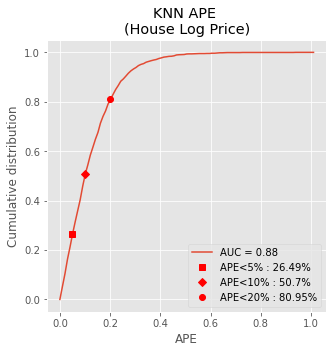

            RMSE    R2  MAPE%   AUC
Value  203252.03  0.84   12.4  0.88


In [21]:
y_pred=np.exp(KNN_opt_log.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred,title="KNN APE \n(House Log Price)")

### K-Fold for log price

             mean        std
RMSE   201964.078  17290.106
R2          0.838      0.026
MAPE%      12.412      0.714
AUC         0.876      0.007


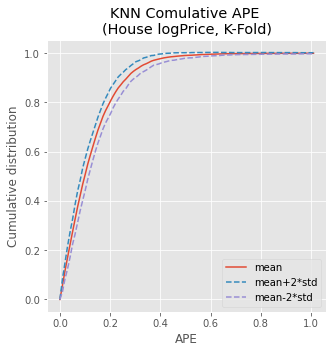

             mean       std
APE<5%   0.274702  0.025356
APE<10%  0.508343  0.032385
APE<20%  0.806558  0.025724


In [11]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    KNN= KNeighborsRegressor(n_neighbors=11,weights='distance',algorithm='brute', p=1,
                             metric='minkowski').fit(nX.iloc[train_index],
                                                     nY.iloc[train_index]['log price'])
    y_pred=np.exp(KNN.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="KNN Comulative APE \n(House logPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Linear regression Coefficients

In [25]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
dict_coef={'Coefficients':LR.coef_}
index_coef=X_train.columns
df = pd.DataFrame(dict_coef,index=index_coef)
df.T


,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Parking Type,Taxes,AC Type,green_new,Date,MortgageRate,...,E09,C13,W10,W05,E06,E02,C09,E01,W01,E07
Coefficients,0.039037,-0.007638,0.15314,0.008778,0.003674,0.103579,0.007269,0.036863,0.076286,-1.049305,...,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07


## Hybrid

### Sold Price

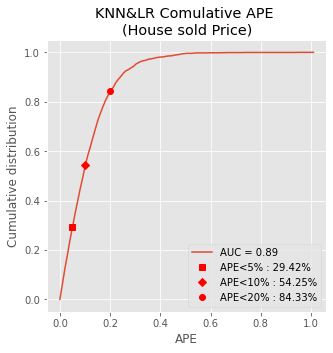

            RMSE    R2  MAPE%   AUC
Value  187416.72  0.86  11.47  0.89


In [24]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=11, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['Sold Price'])
y_pred=KNN.predict(X_test)
score,ES=GoF(Y_test['Sold Price'],y_pred,title="KNN&LR Comulative APE \n(House sold Price)") 

### Hybrid(sp) K-Fold Cross Validation

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50              mean        std
RMSE   186261.950  14681.147
R2          0.862      0.023
MAPE%      11.369      0.616
AUC         0.887      0.006


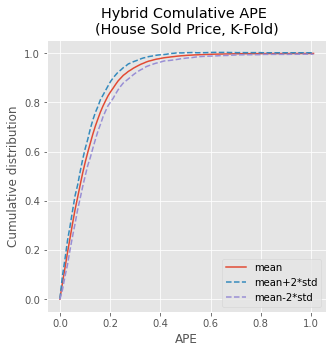

             mean       std
APE<5%   0.308009  0.025962
APE<10%  0.557752  0.027764
APE<20%  0.843801  0.020928


In [13]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR = LinearRegression()
    LR.fit(X_train, Y_train['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR= KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', metric='wminkowski',
                              metric_params={'w': weights},p=1).fit(nX.iloc[train_index],nY.iloc[train_index]['Sold Price'])                                             
                                
    y_pred=KNN_LR.predict(nX.iloc[test_index])
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    print(i,end=' ')
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="Hybrid Comulative APE \n(House Sold Price, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))

### Hybrid(Log of Sold price)

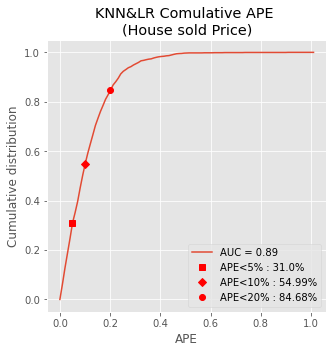

            RMSE    R2  MAPE%   AUC
Value  188036.45  0.86  11.23  0.89


In [25]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=8, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['log price'])
y_pred=np.exp(KNN.predict(X_test))/_MAX_Y
score,ES=GoF(Y_test['Sold Price'],y_pred,title="KNN&LR Comulative APE \n(House sold Price)") 

### Hybrid K-Fold Cross Validation,K=50

             mean        std
RMSE   187434.818  14768.866
R2          0.860      0.022
MAPE%      11.193      0.602
AUC         0.888      0.006


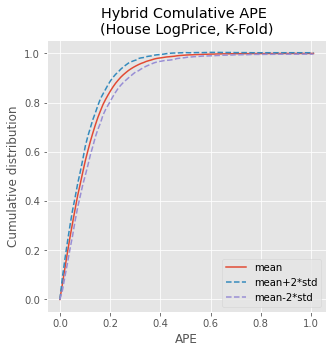

             mean       std
APE<5%   0.310572  0.025917
APE<10%  0.562616  0.029650
APE<20%  0.848134  0.020407


In [14]:
CDF=[]
dict_error={'Value':[0,0,0,0]}
index_error=['RMSE','R2','MAPE%',"AUC"]
ES = pd.DataFrame(dict_error,index=index_error)
num_fold=50
i=0
folds = KFold(n_splits = num_fold, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR = LinearRegression()
    LR.fit(X_train, Y_train['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR= KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', metric='wminkowski',
                              metric_params={'w': weights},p=1).fit(nX.iloc[train_index],nY.iloc[train_index]['log price'])                                             
                                
    y_pred=np.exp(KNN_LR.predict(nX.iloc[test_index]))/_MAX_Y
    cdf,es=GoF(nY.iloc[test_index]['Sold Price'],y_pred,summary=False,plot=False)
    
    CDF.append(cdf)
    ES[i]=es
    i+=1
    
ES=ES.drop('Value',axis=1)
ES['mean']=ES.mean(axis=1)
ES['std']=ES.std(axis=1)
ES=ES[['mean','std']]    
print(ES.round(3))

CDF=np.array(CDF)
CDF_mean=CDF.mean(axis=0)
CDF_std=CDF.std(axis=0)
CDF_plot(CDF_mean,CDF_std,title="Hybrid Comulative APE \n(House LogPrice, K-Fold)")
dict_ACC={'mean':CDF_mean[[5,10,20]],'std':CDF_std[[5,10,20]]}
index_ACC=['APE<5%','APE<10%','APE<20%']
print(pd.DataFrame(dict_ACC,index=index_ACC))